# Exploration of one customer

customer 12:

* no controlled load (CL channel)
* no oddities consumption and production during 2011-2012

Statistics close to the [dataset average](Solar%20home%20exploration.ipynb#Global-statistics-of-PV-generation):
* Consumption: avg 0.7 kW, max 4.0 kW. Yearly total of 5 900 kWh/yr
* PV max 0.9 kW (1.04 kW capacity). Yield of 1250 kWh/yr/kWc

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load customer data

In [2]:
import solarhome as sh

In [3]:
df_raw = sh.read_csv('2011-2012')
df, missing_rec = sh.reshape(df_raw)

In [4]:
n_cust = 12
d = df[n_cust]
d.to_csv('customer/12/data.csv')
d.head()

Channel,GC,GG
2011-07-01 00:00:00,0.392,0.0
2011-07-01 00:30:00,0.578,0.0
2011-07-01 01:00:00,0.568,0.0
2011-07-01 01:30:00,0.482,0.0
2011-07-01 02:00:00,0.456,0.0


In [5]:
d.describe([])

Channel,GC,GG
count,17568.000000,17568.000000
mean,0.676044,0.147587
std,0.351625,0.227503
min,0.000000,0.000000
50%,0.586000,0.000000
max,4.004000,0.900000


Histograms

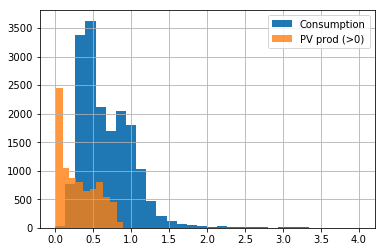

In [22]:
prod = d.GG
cons = d.GC
cons.hist(bins=30, label='Consumption')
(prod[prod>=0.01]).hist(label='PV prod (>0)', alpha=0.8)
plt.legend();

PV yearly production (kWh)

In [23]:
dt = 0.5 # hours
E_pv = prod.sum() * dt
E_pv

1296.4040000000114

In [18]:
d_cust_cap = df_raw[['Customer', 'Generator Capacity']]
gen_cap = d_cust_cap.groupby('Customer')['Generator Capacity'].max()
gen_cap = gen_cap[n_cust]
gen_cap

1.04

In [19]:
E_pv/gen_cap

1246.5423076923187

In [24]:
E_cons = cons.sum() * dt
E_cons

5938.36899999997

### Time plot

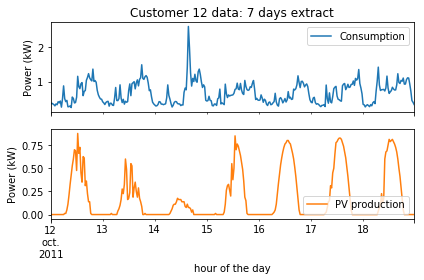

In [244]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

sl = slice('2011-10-12','2011-10-18') # 3 semi-cloudy, 1 very cloudy, 3 sunny days 
#sl=slice(0, -1)
cons[sl].plot(ax=ax1, label='Consumption')
prod[sl].plot(ax=ax2, color='tab:orange', label='PV production')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax1.set(
    title='Customer %d data: 7 days extract' % n_cust,
    ylabel='Power (kW)'
)
ax2.set(
    xlabel='hour of the day',
    ylabel='Power (kW)'
);

fig.tight_layout()
fig.savefig('customer/12/data_week_%s.png' % sl.start, dpi=200, bbox_inches='tight')

## Daily pattern

i.e. stats as a function of the hour of the day

In [9]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

d_dm = d.groupby(by=hod).mean()
d_d05 = d.groupby(by=hod).quantile(.05)
d_d25 = d.groupby(by=hod).quantile(.25)
d_d75 = d.groupby(by=hod).quantile(.75)
d_d95 = d.groupby(by=hod).quantile(.95)

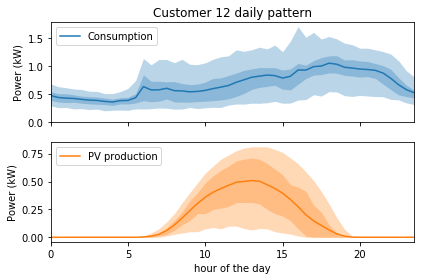

In [120]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

c = 'tab:blue'
d_dm.GC.plot(ax=ax1, color=c, label='Consumption')
ax1.fill_between(d_dm.index, d_d05.GC, d_d95.GC, alpha=0.3, color=c, lw=0)
ax1.fill_between(d_dm.index, d_d25.GC, d_d75.GC, alpha=0.3, color=c, lw=0)
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper left')

c = 'tab:orange'
d_dm.GG.plot(ax=ax2, color=c, label='PV production')
ax2.fill_between(d_dm.index, d_d05.GG, d_d95.GG, alpha=0.3, color=c, lw=0)
ax2.fill_between(d_dm.index, d_d25.GG, d_d75.GG, alpha=0.3, color=c, lw=0)
ax2.legend(loc='upper left')

ax1.set(
    title='Customer %d daily pattern' % n_cust,
    ylabel='Power (kW)'
);
ax2.set(
    xlabel='hour of the day',
    ylabel='Power (kW)'
);
fig.tight_layout()
fig.savefig('customer/12/daily_pattern_2011-2012.png', dpi=200, bbox_inches='tight')

#### Compute all quantiles, to save the pattern for later reuse

In [121]:
quantiles = np.linspace(0.05, 0.95, 19)
quantiles

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95])

In [123]:
def daily_pattern(ts):
    '''compute statistics for each hour of the day (min, max, mean and quantiles)
    of the time series `ts`
    
    returns DataFrame with columns 'mean','min', 'qXX'..., 'max'
    and rows being the hours of the day between 0. and 24.
    '''
    dstats = pd.DataFrame({
        'q{:02.0f}'.format(q*100) : ts.groupby(by=hod).quantile(q)
        for q in quantiles
    })
    dstats.insert(0, 'min',  ts.groupby(by=hod).min())
    dstats.insert(0, 'mean', ts.groupby(by=hod).mean())
    dstats['max'] = ts.groupby(by=hod).max()
    return dstats

In [124]:
prod_dstats = daily_pattern(d.GG)
prod_dstats.to_csv('customer/12/daily_pattern_prod_2011-2012.csv')

cons_dstats = daily_pattern(d.GC)
cons_dstats.to_csv('customer/12/daily_pattern_cons_2011-2012.csv')

In [236]:
def plot_daily_pattern(dstats, title):
    fig, ax = plt.subplots(1,1)
    
    q_names = [c for c in dstats.columns if c.startswith('q')]
    
    dstats[q_names[:9]].plot(ax=ax, color='tab:blue', lw=1)
    dstats['q50'].plot(ax=ax, color='k')
    dstats[q_names[11:]].plot(ax=ax, color='tab:red', lw=1)
    dstats['min'].plot(ax=ax, color='tab:blue', label='min')
    dstats['max'].plot(ax=ax, color='tab:red')
    dstats['mean'].plot(ax=ax, color='k', lw=4, alpha=0.5)
    plt.legend(ax.lines[-3:], ['min', 'max', 'mean']);
    
    ax.set(
        xlabel='hour of the day',
        ylabel='Power (kW)',
        title=title)
    fig.tight_layout()
    return fig, ax

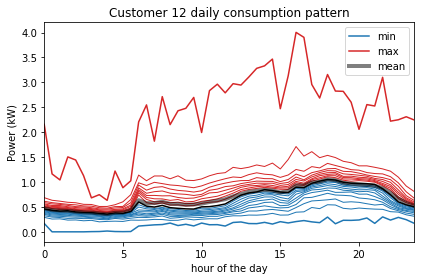

In [239]:
fig, ax = plot_daily_pattern(cons_dstats,
    title='Customer %d daily consumption pattern' % n_cust)
fig.savefig('customer/12/daily_pattern_cons_2011-2012.png', dpi=200)

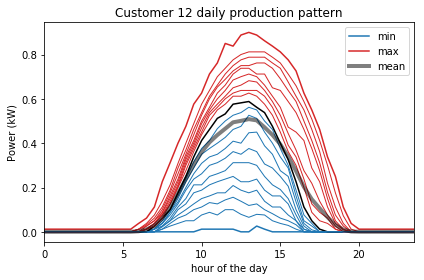

In [240]:
fig, ax = plot_daily_pattern(prod_dstats,
   title='Customer %d daily production pattern' % n_cust)
fig.savefig('customer/12/daily_pattern_prod_2011-2012.png', dpi=200)

#### Compute same quantiles, but on the month before the week extract above

In [145]:
sl = slice('2011-09-12','2011-10-11')
#sl = '2011-10'

daily_pattern(cons[sl]).to_csv('customer/12/daily_pattern_cons_M-1-%s.csv' % sl.stop)
daily_pattern(prod[sl]).to_csv('customer/12/daily_pattern_prod_M-1-%s.csv' % sl.stop)

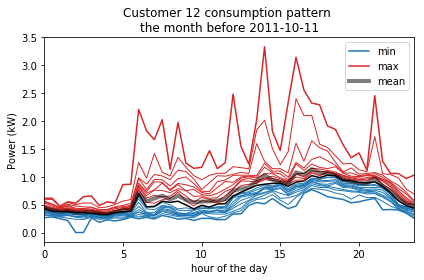

In [242]:
fig, ax = plot_daily_pattern(daily_pattern(cons[sl]),
    title='Customer %d consumption pattern \nthe month before %s' % (n_cust, sl.stop))
fig.savefig('customer/12/daily_pattern_cons_M-1-%s.png' % sl.stop, dpi=200)

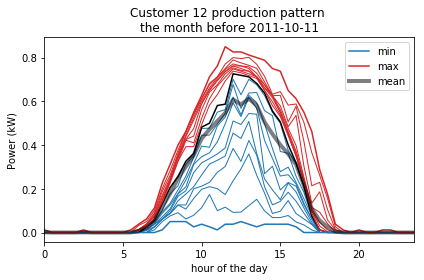

In [243]:
fig, ax = plot_daily_pattern(daily_pattern(prod[sl]),
    title='Customer %d production pattern \nthe month before %s' % (n_cust, sl.stop))
fig.savefig('customer/12/daily_pattern_prod_M-1-%s.png' % sl.stop, dpi=200)

## Day ahead forecast

model: autoregression on the previous half-hour, the previous day, with effect of the hour of the day.

$$ y_k = f(y_{k-1}, y_{k-48}, h)  $$

More precisely, linear autogression, with coefficient being dependant of the hod:

$$ y_k = a_0(h) + a_1(h).y_{k-1} + a_2(h).y_{k-48} $$

In addition, the series of coefficients $a_0(h)$, $a_1(h)$, $a_2(h)$,... may require some smoothing, that is a penalization of their variations. Either absolute variation around average time-indepent coefficients or variation along the day.

→ pivoted data is saved for further processing in Julia: [Forecast.ipynb](Forecast.ipynb)

### Data preparation: group by day (pivoting)

pivot data: one day per row, one hour per column

In [146]:
d1 = d.copy()
d1['date'] = pd.DatetimeIndex(d1.index.date)
d1['hod'] = hod(d1.index)
d1.head()

Channel,GC,GG,date,hod
2011-07-01 00:00:00,0.392,0.0,2011-07-01,0.0
2011-07-01 00:30:00,0.578,0.0,2011-07-01,0.5
2011-07-01 01:00:00,0.568,0.0,2011-07-01,1.0
2011-07-01 01:30:00,0.482,0.0,2011-07-01,1.5
2011-07-01 02:00:00,0.456,0.0,2011-07-01,2.0


In [247]:
prod_dpivot = d1.pivot('date', 'hod', 'GG')
cons_dpivot = d1.pivot('date', 'hod', 'GC')
cons_dpivot.head(3)

hod,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,19.0,19.5,20.0,20.5,21.0,21.5,22.0,22.5,23.0,23.5
date,,,,,,,,,,,,,,,,,,,,,
2011-07-01,0.392,0.578,0.568,0.482,0.456,0.398,0.388,0.442,0.398,0.260,...,0.842,0.858,0.864,0.792,0.808,0.668,0.688,0.720,0.478,0.476
2011-07-02,0.504,0.454,0.394,0.302,0.390,0.366,0.198,0.270,0.270,0.274,...,0.766,0.786,0.762,0.772,0.776,0.584,0.368,0.452,0.474,0.540
2011-07-03,0.592,0.478,0.364,0.448,0.400,0.198,0.306,0.300,0.214,0.326,...,0.372,0.350,0.492,0.552,0.654,0.714,0.520,0.478,0.480,0.440


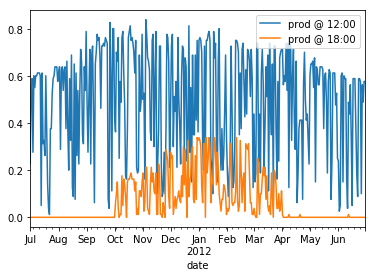

In [149]:
prod_dpivot[12.0].plot(label='prod @ 12:00')
prod_dpivot[18.0].plot(label='prod @ 18:00')
plt.legend();

Save as CSV for further use

In [151]:
prod_dpivot.to_csv('customer/12/daily_pivot_prod_2011-2012.csv')

cons_dpivot.to_csv('customer/12/daily_pivot_cons_2011-2012.csv')

### PV Production heatmap

Notice the effect of **daylight saving** between days ~92 (Oct 1st) and ~274 (March 31st).

→ this is a *problem for forecasting*

In [219]:
prod_dpivot.index[92], prod_dpivot.index[274]

(Timestamp('2011-10-01 00:00:00'), Timestamp('2012-03-31 00:00:00'))

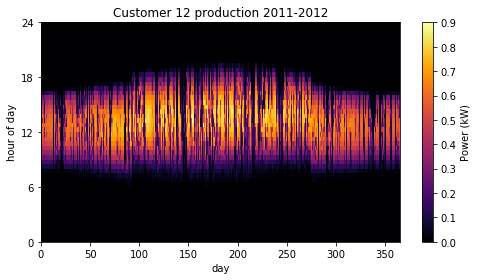

In [232]:
fig = plt.figure(figsize=(7,4))
plt.imshow(prod_dpivot.values.T, aspect='auto',
           origin='lower', extent=[0, 365, 0, 24], cmap='inferno');
plt.ylim([4, 20])
cbar = plt.colorbar()
cbar.set_label('Power (kW)')
cbar.locator

ax = plt.gca()
ax.set(
    title='Customer %d production 2011-2012' % n_cust,
    xlabel='day',
    ylabel='hour of day',
    yticks=[0, 6, 12, 18, 24]
)
fig.tight_layout()
fig.savefig('customer/12/daily_pivot_prod_2011-2012.png', dpi=200, bbox_inches='tight')

### Consumption heatmap

Notice: vmax set to 2 kW (→ saturation) otherwise the plot is dominated by the few spikes between 2.5 and 4 kW

Obs:

* start of the day at 6 am. Not influenced by daylight saving

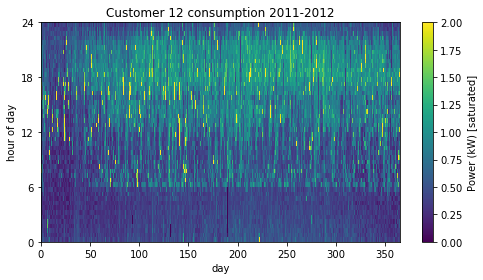

In [226]:
fig = plt.figure(figsize=(7,4))
plt.imshow(cons_dpivot.values.T, aspect='auto',
           vmax=2,
           origin='lower', extent=[0, 365, 0, 24]);
#plt.ylim([4, 20])
cbar = plt.colorbar()
cbar.set_label('Power (kW) [saturated]')
fig.tight_layout()

ax = plt.gca()
ax.set(
    title='Customer %d consumption 2011-2012' % n_cust,
    xlabel='day',
    ylabel='hour of day',
    yticks=[0, 6, 12, 18, 24]
)
fig.tight_layout()
fig.savefig('customer/12/daily_pivot_cons_2011-2012.png', dpi=200, bbox_inches='tight')

Same plot, without saturation, but using a compression of high values:

$$ v \to \sqrt{v/v_{max}}$$

In [193]:
v = cons_dpivot.values.T
v = v/v.max()
v = v**(0.5)

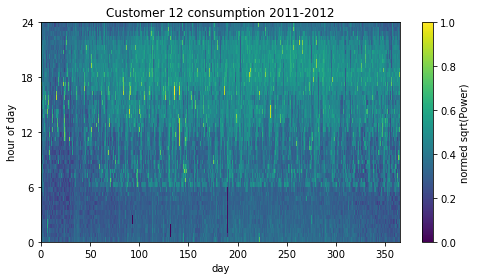

In [205]:
fig = plt.figure(figsize=(7,4))
plt.imshow(v, aspect='auto',
           origin='lower', extent=[0, 365, 0, 24]);
#plt.ylim([4, 20])
cbar = plt.colorbar()
cbar.set_label('normed sqrt(Power)')

ax = plt.gca()
ax.set(
    title='Customer %d consumption 2011-2012' % n_cust,
    xlabel='day',
    ylabel='hour of day',
    yticks=[0, 6, 12, 18, 24]
)
fig.tight_layout()